In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from statsmodels.stats.contingency_tables import mcnemar
from tqdm import tqdm
from sklearn import model_selection

In [ ]:
# Setup

from data_analysis import data_frame

data_frame['dis'][ data_frame['dis'] == 'NA' ] = 5
data_frame['obs'][ data_frame['obs'] == 'NA' ] = 3


from data_analysis import p_dis, p_obs, p_prs

significant_dis = p_dis <= 0.05/900
significant_obs = p_obs <= 0.05/900
significant_prs = p_prs <= 0.05/900

In [ ]:
# Train the model

similarity_matrix_xyz = np.zeros((1600,1600))

similarity_matrix_xy = np.zeros((1600,1600))
similarity_matrix_xz = np.zeros((1600,1600))
similarity_matrix_yz = np.zeros((1600,1600))

similarity_matrix_dis = np.zeros((1600,1600))
similarity_matrix_obs = np.zeros((1600,1600))

similarity_matrix_left_hand = np.zeros((1600,1600))

for x in tqdm(range(1600)):
    for y in range(1600):
        X = data_frame['data'][x]
        Y = data_frame['data'][y]
        
        X_flipped = data_frame['data'][x]
        
        X_flipped[1] *=  -1
        
        diff = (X - Y)**2
        
        sim_xyz = diff.mean()
        
        sim_left = ((X_flipped - Y)**2).mean()
        similarity_matrix_left_hand[x,y] = sim_left
        
        sim_xy = diff[:, (0,1)].mean()
        sim_xz = diff[:, (0,2)].mean()
        sim_yz = diff[:, (1,2)].mean()
        
        sim_dis = diff[significant_dis].mean()
        sim_obs = diff[significant_obs].mean()
        
        
        similarity_matrix_xyz[x,y] = sim_xyz
        
        similarity_matrix_xy[x,y] = sim_xy
        similarity_matrix_xz[x,y] = sim_xz
        similarity_matrix_yz[x,y] = sim_yz
        
        similarity_matrix_dis[x,y] = sim_dis
        similarity_matrix_obs[x,y] = sim_obs

In [ ]:
similarity_matrix = similarity_matrix_left_hand

most_similar = np.argsort(similarity_matrix, axis=1)

In [ ]:
model_parameters = [1, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47, 53, 59]

def k_nearest(X, not_indexes, s_parameter, y_labels, most_similar):
    sim_list_ = most_similar[X]
    
    sim_list = []
    
    for e in sim_list_:
        if len(sim_list) >= s_parameter:
            break
        if e not in not_indexes:
            sim_list += [e]
    else:
        print("Der skete en fejl her din spade")
        
    y_list = y_labels[sim_list]
        
    vals_, index_, counts_ = np.unique(y_list, return_counts=True, return_index=True)
    
    vals = vals_[np.argsort(index_)]
    counts = counts_[np.argsort(index_)]
    
    index = np.argmax(counts)
    
    return vals[index]


def train_model(not_indexes, s_parameter, y_labels):
    return lambda X: k_nearest(X, not_indexes, s_parameter, y_labels)

In [ ]:
# Calculate matrix of p-values for the different classifiers being identical

y_labels = np.array(data_frame['obs'])
similarity_matrices = [similarity_matrix_xyz, similarity_matrix_xy, similarity_matrix_xz, similarity_matrix_yz, similarity_matrix_dis, similarity_matrix_obs, similarity_matrix_left_hand]
classifiers = []
for similarity_matrix in similarity_matrices:
    classifiers.append(np.argsort(similarity_matrix, axis = 1))

classifier_p_values = np.zeros((len(classifiers), len(classifiers)))
for i in range(len(classifiers)):
    for j in range(len(classifiers)):
        mc_nemar_matrix = np.zeros((2, 2))
        for k in range(1600):
            i_correct = k_nearest(k, [k], 20, y_labels, classifiers[i]) == y_labels[k]
            j_correct = k_nearest(k, [k], 20, y_labels, classifiers[j]) == y_labels[k]
            mc_nemar_matrix[int(i_correct), int(j_correct)] += 1
        classifier_p_values[i, j] = mcnemar(mc_nemar_matrix, correction = False).pvalue

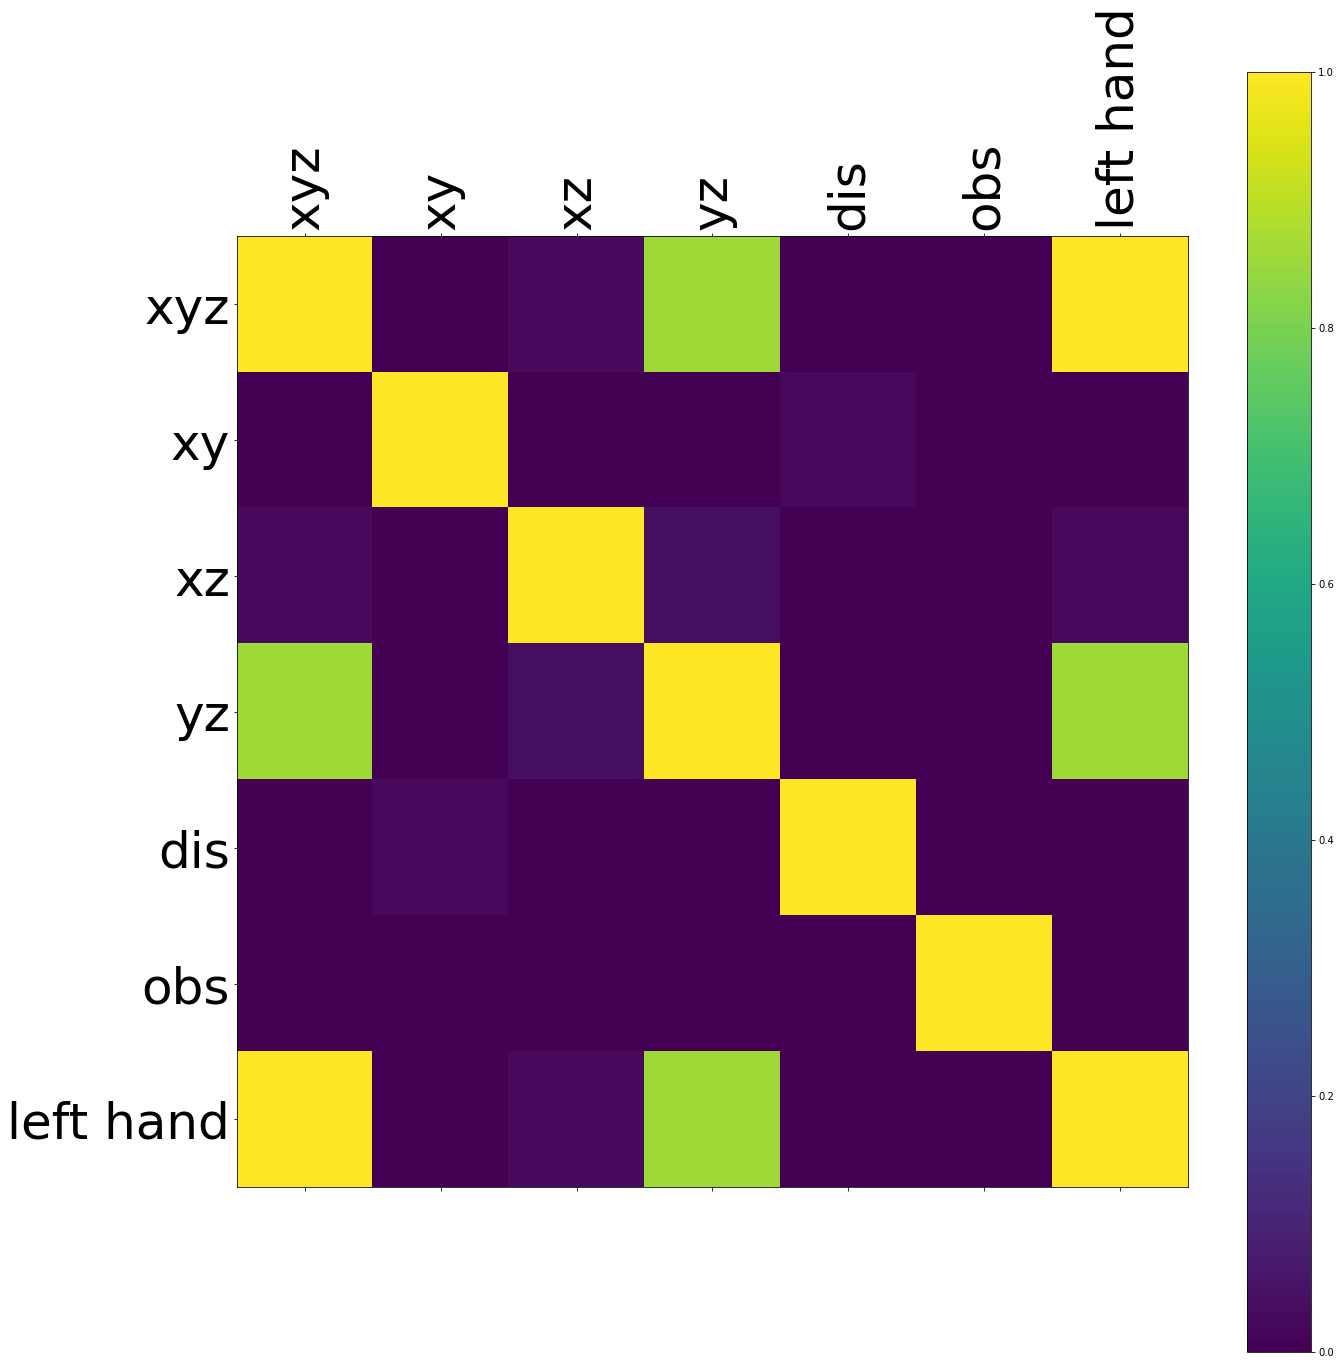

In [56]:
labels = ["xyz", "xy", "xz", "yz", "dis", "obs", "left hand"]

fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(111)
cax = ax.matshow(classifier_p_values)
fig.colorbar(cax)
ax.set_xticks(range(len(labels)))
ax.set_yticks(range(len(labels)))
ax.set_xticklabels(labels, fontsize = 50)
ax.set_yticklabels(labels, fontsize = 50)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [ ]:
# Two layer cross validation

# inits
y_labels = np.array(data_frame['obs'])

generalization_error = 0
generalization_error_s = np.zeros(len(model_parameters))
all_generalization_error_s = []
best_test_error = []
best_test_lambda = []


for fold1 in tqdm(range(10)):
    X_par_prs = data_frame[ data_frame['prs'] != fold1 ]['prs']
    
    par_indexes = np.arange(1600)[ data_frame['prs'] != fold1 ]
    test_indexes = np.arange(1600)[ data_frame['prs'] == fold1 ]
    
    fold2values = list(range(10))
    fold2values.remove(fold1)
    
    for fold2 in fold2values:
        train_indexes = par_indexes[ X_par_prs != fold2 ]
        val_indexes = par_indexes[ X_par_prs == fold2 ]
        
        for s_count, s_parameter in enumerate(model_parameters):
            not_indexes = np.hstack((test_indexes, val_indexes))
            model_s = train_model(not_indexes, s_parameter, y_labels)
            
            y_val = y_labels[val_indexes]
            y_val_estimates = np.array([model_s(X) for X in val_indexes])
            
            generalization_error_s[s_count] += len(val_indexes)/len(par_indexes) * np.mean(y_val_estimates != y_val)
            
    
    # get and save generalization error for model s + select best model
    best_model_index = np.argmin(generalization_error_s)
    best_model_parameters = model_parameters[best_model_index]
    
    all_generalization_error_s.append(generalization_error_s)
    generalization_error_s = np.zeros(len(model_parameters))
    
    # calculate generalization error
    best_model = train_model(test_indexes, best_model_parameters, y_labels)
    
    y_test = y_labels[test_indexes]
    y_test_estimates = np.array([best_model(X) for X in test_indexes])
    
    best_test_lambda.append(best_model_parameters)
    best_test_error.append(np.mean(y_test_estimates != y_test))
    
    generalization_error += len(test_indexes)/len(data_frame) * np.mean(y_test_estimates != y_test)


average_generalization_error_s = np.mean(np.array(all_generalization_error_s), axis=0)

parameter_overview = list(zip(model_parameters, average_generalization_error_s))

In [ ]:
# Generate confusion matrices

model_parameter = 3


exp2distance = {i: i%5 for i in range(15)}
exp2distance[15] = 5

exp2obstacle = {i: i%3 for i in range(15)}
exp2obstacle[15] = 3

confussion_experiment = np.zeros((16,16))
confussion_distance = np.zeros((6,6))
confussion_obstacle = np.zeros((4,4))

# inits
y_labels = np.array(data_frame['exp'])

for fold1 in tqdm(range(10)):
    train_indexes = np.arange(1600)[ data_frame['prs'] != fold1 ]
    test_indexes = np.arange(1600)[ data_frame['prs'] == fold1 ]
    
    not_indexes = test_indexes
    model_s = train_model(not_indexes, model_parameter, y_labels)
    
    y_val = y_labels[val_indexes]
    y_val_estimates = np.array([model_s(X) for X in val_indexes])
    
    for y_pred, y_true in zip(y_val_estimates, y_val):
        confussion_experiment[y_pred, y_true] += 1
        confussion_distance[exp2distance[y_pred], exp2distance[y_true]] += 1
        confussion_obstacle[exp2obstacle[y_pred], exp2obstacle[y_true]] += 1

In [ ]:
# Plot confusion matrices

cms = [confussion_experiment, confussion_distance, confussion_obstacle]
all_labels = [range(1,17), ['15cm', '22.5cm', '30cm', '37.5cm', '45cm', 'NA'], ['S', 'M', 'T', 'NA']]

for cm, labels in zip(cms, all_labels):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    fig.colorbar(cax)
    ax.set_xticks(range(len(labels)))
    ax.set_yticks(range(len(labels)))
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)
    plt.tight_layout()
    plt.show()